<a href="https://colab.research.google.com/github/good0neighbour/ESTCampAI/blob/main/Deeplearning/04_1_%EA%B0%9C%2C_%EA%B3%A0%EC%96%91%EC%9D%B4_%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8%EB%A7%81(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ESTCampAI/Deeplearning

/content/drive/MyDrive/ESTCampAI/Deeplearning


### MLP
1. 이미지 위치에 민감 → 모든 픽셀을 연산
숫자 인식을 하려면 크기, 위치를 비슷하게 해야 가능
2. 2차원 이미지를 1차원화하면서(Flatten 사용) 위치 관계에 대한 정보도 잃었음

### CNN(Convolutional Neural NetWork)
- 특징 부분을 추출
- MLP 기반으로 만들어진 모델!


### 목표
- MLP, CNN 모델을 활용해서 이미지 분류 모델링 실습
    -> 두 모델 성능 비교!
- 딥러닝 성능을 올릴 수 있는 방법들도 배워보자!

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# npz 파일 불러오기
data = np.load('./data/np_cat_vs_dogs.npz')


In [ ]:
X_train =data['X_train']
X_test =data['X_test']
y_train =data['y_train']
y_test =data['y_test']

In [ ]:
# 모양 확인
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2000, 224, 224, 3), (1000, 224, 224, 3), (2000,), (1000,))

### MLP 모델링 수행
1. 신경망 구조 설계
- Flatten 넣어주기!!
- 중간층  3개 layer, units=[256, 128, 64], 활성화함수 ='relu'
2. 학습 방법 설정
- adam, accuracy
- 조기학습중단 : val set 5회
3. 학습
- epochs = 40, validation_split = 30%
4. 시각화 train_acc, val_acc

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 1. 신경망 구조 설계
# 1-1) 뼈대
mlp_model = Sequential()

# 1-2) 입력층
mlp_model.add(InputLayer(shape=(224, 224, 3)))

# 사진 펼치기
mlp_model.add(Flatten()) # 다차원을 1차원으로 변환

# 1-3) 중간층
mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dense(64, activation='relu'))

# 1-4) 출력
mlp_model.add(Dense(1, activation='sigmoid')) # 개, 고양이 → 이진분류

In [ ]:
# 2. 학습 방법 설정
mlp_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# 2-1. 조기 학습 중단 설정
early = EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
mlp_his = mlp_model.fit(X_train, y_train, validation_split=0.3, epochs=40, callbacks=[early])

Epoch 1/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 730ms/step - accuracy: 0.5699 - loss: 2722.3271 - val_accuracy: 0.9567 - val_loss: 4.4983
Epoch 2/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 740ms/step - accuracy: 0.6033 - loss: 363.6861 - val_accuracy: 0.6133 - val_loss: 94.9561
Epoch 3/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 719ms/step - accuracy: 0.6452 - loss: 141.5935 - val_accuracy: 0.0000e+00 - val_loss: 1225.1064
Epoch 4/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 749ms/step - accuracy: 0.6004 - loss: 405.9807 - val_accuracy: 0.0000e+00 - val_loss: 1962.7417
Epoch 5/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 742ms/step - accuracy: 0.6167 - loss: 380.5539 - val_accuracy: 0.4883 - val_loss: 110.9306
Epoch 6/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 724ms/step - accuracy: 0.6809 - loss: 96.8202 - val_accuracy: 0.0000e+00 - val_loss: 2491.9211


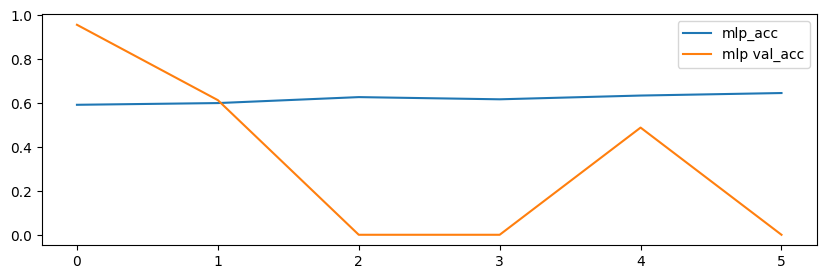

In [ ]:
# 4. 시각화
plt.figure(figsize=(10, 3))
plt.plot(mlp_his.history['accuracy'], label="mlp_acc")
plt.plot(mlp_his.history['val_accuracy'], label="mlp val_acc")
plt.legend()
plt.show()

# 모델이 학습을 제대로 수행하지 못함!(과소적합)
# MLP 특성상 픽셀의 위치값에 의존하기 때문에 학습의 성능이 떨어질 수 밖에 없음

In [ ]:
# 필요 라이브러리 로딩
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# Conv2D : 특징을 잡아내는 역할을 하는 모듈
# MaxPooling2D : 중요한 정보만 걸러내는 모듈

### CNN(Convolutional Neural Network, 합성곱 신경망)
- 이미지나 영상 같은 시각 데이터를 처리하는데 특화된 딥러닝 모델
- 사람의 시각시스템을 모방하여 설계

1. 모델 설계
    - 뼈대 생성
    - 특성 추출부(Conv, Pool)
    - 분류부(MLP)
2. 학습 방법 설정
3. 학습
4. 예측 평가

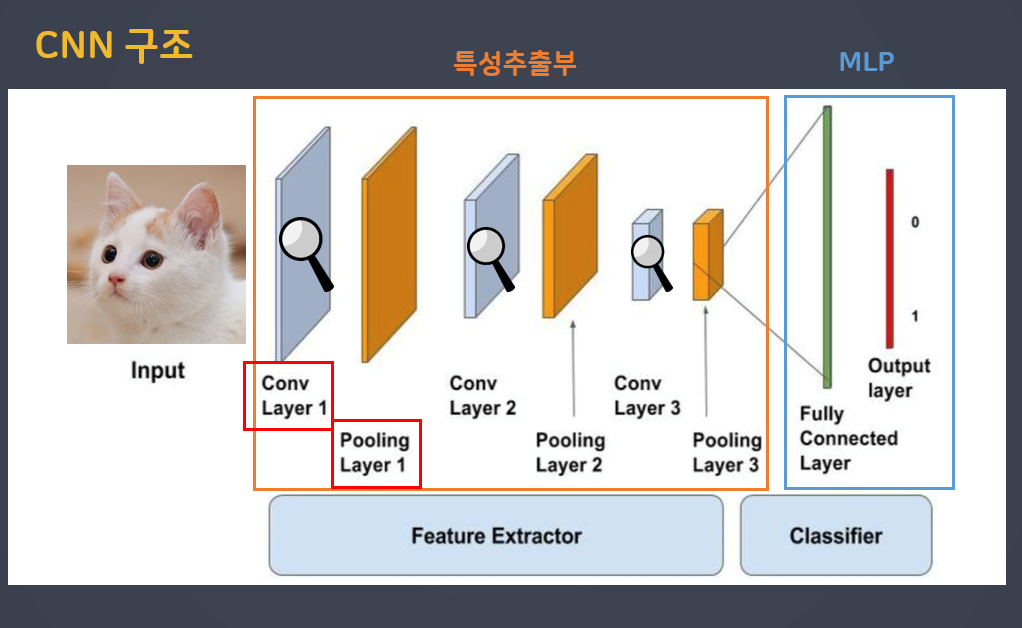

In [ ]:
# 1. 설계
# 1-1) 뼈대 설계
cnn_model = Sequential()
# 1-2) 입력층
cnn_model.add(InputLayer(shape=(224, 224, 3)))

# 1-3) 특성추출부(Feature Extractor)
# 특징 추출 연산
cnn_model.add(
    Conv2D(
        filters=32,         # 커널(필터)의 개수
        kernel_size=(3,3),  # 커널(필터)의 사이즈
        activation="relu",
        padding="same",     # 패딩 : 입출력의 크기를 동일하게 맞추기위해 가장자리에 숫자(보통 0)를 채워넣는 기능
                            # same : 이미지 자체가 작거나 혹은 가장자리 정보가 중요할때
                            # valid : 이미지 자체가 클 때(특징들이 많을 때)
        strides=(2,2)       # 커널의 이동 보폭 : 양 옆, 위 아래로 2픽셀씩 커널을 이동
    )
)
# 이미지의 경계선, 질감 같은 국소적인 특징을 추출가능

# 압축 및 요약
cnn_model.add(MaxPooling2D(
    pool_size=(2,2)   # 풀링 윈도우 : 보통 2*2, 3*3을 많이 사용
))

# max pooling : 풀링 윈도우에서 최대값만 넘김
# average pooling : 풀링 윈도우의 평균값을 넘김

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# 1-4) 분류부(MLP)
cnn_model.add(Flatten()) # 다차원을 1차원으로 변환

# 중간층
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(64, activation='relu'))

# 1-5) 출력
cnn_model.add(Dense(1, activation='sigmoid')) # 개, 고양이 → 이진분류


In [ ]:
# 2. 학습 방법 설정
cnn_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [ ]:
# 3. 학습
cnn_his = cnn_model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=20,
    batch_size=64 # 전체 데이터 셋을 나누는 크기
    # 전체 데이터 셋을 batch_size로 나눠서 모든 구간을 학습 반영 -> 1 epoch
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5966 - loss: 3.7329 - val_accuracy: 0.0850 - val_loss: 1.1034
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 996ms/step - accuracy: 0.6161 - loss: 0.6850 - val_accuracy: 0.0000e+00 - val_loss: 1.3725
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 910ms/step - accuracy: 0.7001 - loss: 0.6129 - val_accuracy: 0.0000e+00 - val_loss: 1.5384
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7304 - loss: 0.5597 - val_accuracy: 0.1250 - val_loss: 1.0451
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 915ms/step - accuracy: 0.7421 - loss: 0.5248 - val_accuracy: 0.4583 - val_loss: 0.7779
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 908ms/step - accuracy: 0.7798 - loss: 0.5009 - val_accuracy: 0.4733 - val_loss: 0.7808
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 999ms/step - accuracy: 0.7813 - loss: 0.4764 - val_accuracy: 0.5967 - val_loss: 0.6772
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 893ms/step - accuracy: 0.8038 - loss: 0.4335 - val_ac

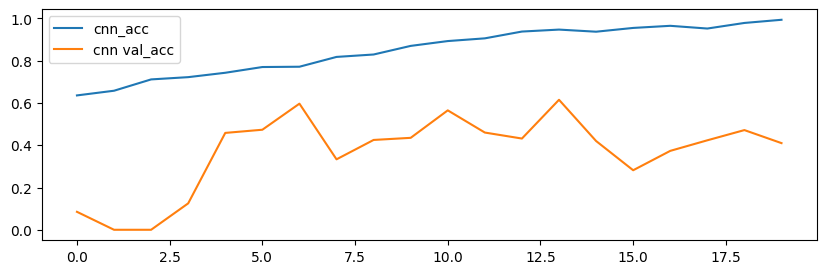

In [ ]:
# 4. 시각화
plt.figure(figsize=(10, 3))
plt.plot(cnn_his.history['accuracy'], label="cnn_acc")
plt.plot(cnn_his.history['val_accuracy'], label="cnn val_acc")
plt.legend()
plt.show()

#  MLP 보다는 좀 더 학습이 됐긴 함(train 데이터에서 정확도가 좀 올랐음!)
# train 데이터에 너무 맞춰졌기 때문에 (과대 적합)
# 이미지 증강!!


### 딥러닝 성능을 올려보자!
- 이미지 데이터 증강(Data augmentation) : 이미지 회전, 이동, 확대, 축소, 뒤집기 등을 통해서 새로운 데이터가 추가된 것처럼 **train데이터의 개수를 늘리는 방법**

- Train 데이터에만!!! 증강 적용

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 증강할 데이터(원본) 경로 할당
train_dir = "./data/cats_and_dogs_filtered/train"
test_dir = "./data/cats_and_dogs_filtered/test"

| 옵션               | 설명                                                       |
|--------------------|------------------------------------------------------------|
| `rescale`          | 입력 이미지의 픽셀 값 재조정(ex.rescale=1.255 -> 모든 픽셀값들에 대해 0~1 사이로 정규화)|
| `rotation_range`   | 이미지의 회전 범위를 설정(ex.rotation_range -> -20~20도 사이에서 무작위로 회전)|
| `width_shift_range`| 이미지의 수평 이동 범위를 설정(ex.0.1은 전체 너비의 10%만큼 좌우로 무작위로 이동) |
| `height_shift_range`| 이미지의 수직 이동 범위를 설정(ex.0.1은 전체 너비의 10%만큼 위아래로 무작위로 이동)|
| `shear_range`      | 시계 반대 방향으로 지정된 각도만큼 변형       |
| `zoom_range`       | 이미지의 확대 및 축소 범위를 설정(ex.0.1 -> 0.9배~1.1배 사이에서 무작위로 확대하거나 축소) |
| `horizontal_flip`  | 이미지를 수평 방향으로 뒤집을지 여부를 설정       |
| `fill_mode`        | 이미지를 변형할 때 생기는 빈 공간을 채우는 방식을 설정(ex.nearest -> 가장 가까운 픽셀값을 사용하여 빈공간 채우기) |

In [ ]:
# 이미지 증강 도구 셋팅
train_gen = ImageDataGenerator(
    rescale=1./255,  # 모든 이미지의 픽셀값을 0~1 사이로 정규화
    zoom_range=0.2, # 0.8배~1.2배 사이에서 무작위로 확대, 축소
    horizontal_flip = True
)

test_gen = ImageDataGenerator(rescale=1./255) # 테스트 데이터는 정규화만 수행!

In [ ]:
# 이미지 증강
train_generator = train_gen.flow_from_directory(
    train_dir,   # 원본 데이터 경로
    target_size=(224, 224), # 원본 데이터 크기
    batch_size=32,          # 한번에 학습시킬 이미지의 개수
    class_mode = "binary"   # binary : 이진분류
)

test_generator = test_gen.flow_from_directory(
    test_dir,   # 원본 데이터 경로
    target_size=(224, 224), # 원본 데이터 크기
    batch_size=32,          # 한번에 학습시킬 이미지의 개수
    class_mode = "binary"   # binary : 이진분류
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

### Dropout
- 신경망의 노드들을 지정한 비율만큼 비활성화
- 학습하는 동안에만 적용
- 모델이 학습데이터를 너무 외워버리지 않도록(과대적합 방지) 일부 뉴런을 랜덤하게 꺼버리는(비활성화) 기술

In [ ]:
from tensorflow.keras.layers import Dropout

In [ ]:
# 1. 설계
# 1-1 뼈대
cnn_model2 = Sequential()
# 1-2 입력층
cnn_model2.add(InputLayer(shape=(224, 224, 3)))
# 1-3 특성 추출부

cnn_model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding="same", strides=(2,2)))
cnn_model2.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model2.add(Dropout(0.3)) # 학습 시 30%의 노드를 랜덤하게 비활성화 시키겠다


cnn_model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same", strides=(2,2)))
cnn_model2.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding="same", strides=(2,2)))
cnn_model2.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model2.add(Dropout(0.3))

# MLP
cnn_model2.add(Flatten())

cnn_model2.add(Dense(256, activation='relu'))
cnn_model2.add(Dropout(0.3))
cnn_model2.add(Dense(128, activation='relu'))
cnn_model2.add(Dense(64, activation='relu'))

cnn_model2.add(Dense(1, activation='sigmoid'))

In [ ]:
# 학습 방법 설정
cnn_model2.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=["accuracy"]
)

In [ ]:
# 3. 학습
cnn2_his = cnn_model2.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
51/63 ━━━━━━━━━━━━━━━━━━━━ 1:16 6s/step - accuracy: 0.4870 - loss: 0.7032

In [ ]:
cnn_model2.save("ey_model.keras")

In [ ]:
# 모델 불러오기

from tensorflow.keras.models import load_model

loaded_model = load_model("ey_model.keras")

In [ ]:
loaded_model

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(cnn_his.history['accuracy'], label="cnn acc")
plt.plot(cnn_his.history['val_accuracy'], label="cnn val acc")
plt.plot(cnn2_his.history['accuracy'], label = "cnn2 acc")
plt.plot(cnn2_his.history['val_accuracy'], label = "cnn2 val acc")
plt.legend()
plt.show()

# 기존 모델에 비해서는 일반화성능이 확보가 된것같음
# 이미지 증강은 데이터를 변형시켜서 학습을 하는 기법이기 때문에 훨씬 더 많은 epochs를 요구

### 전이학습(Transfer Learning)
- 사전에 미리 학습된 모델을 활용해서 예측을 하는 방법
  - 학습 빠르게 수행 가능!
- 작은 데이터셋에 대해서도 학습할때 효과적
- 완전히 똑같은 데이터 셋으로 학습 사전학습 모델은 찾기 어려움
- 현재 우리의 목표 : 개vs고양이
- 사전 학습 모델 : 사자 vs 호랑이 vs 코끼리...

### VGG16
“복잡한 필터 대신, **작은 3×3 필터를 여러 번 쌓자!”
작은 필터를 여러 번 적용하면 넓은 영역의 특징을 단계적으로 파악할 수 있고,계산량도 효율적으로 줄일 수 있음

총 16개의 학습 레이어 (13개 Conv + 3개 FC)

| 구분               | 구성                                      | 설명               |
| ---------------- | --------------------------------------- | ---------------- |
| **입력**           | (224 × 224 × 3) 이미지                     | RGB 이미지 입력       |
| **Conv 블록 1**    | Conv(3×3, 64) ×2 + MaxPooling           | 작은 필터 2개 후 다운샘플링 |
| **Conv 블록 2**    | Conv(3×3, 128) ×2 + MaxPooling          | 특징 더 많이 추출       |
| **Conv 블록 3**    | Conv(3×3, 256) ×3 + MaxPooling          | 더 깊은 특징          |
| **Conv 블록 4**    | Conv(3×3, 512) ×3 + MaxPooling          | 고차원 특징           |
| **Conv 블록 5**    | Conv(3×3, 512) ×3 + MaxPooling          | 최종 특징 추출         |
| **Flatten + FC** | Dense(4096) → Dense(4096) → Dense(1000) | 최종 분류 단계         |


Conv(3×3, 64) -> “3×3 크기의 필터(filter, 혹은 커널)를 64개 사용하는 합성곱(convolution) 연산을 한다” 라는 뜻

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
# 모델 불러오기
vgg16 = VGG16(
    include_top=False,  # 분류부 제외
    weights ="imagenet",  # 이미지넷 경진대회 데이터셋(1000개의 클래스를 가진 동물데이터)으로 학습된 가중치
    input_shape=(224, 224, 3) # 입력 모양 지정
)

In [ ]:
# 모델 요약 출력
vgg16.summary()

In [ ]:
# 특성 추출부의 갱신을 막음 → 이미 잘 학습 되어있는 모델의 가중치 동결!
for layers in vgg16.layers :
  layers.trainable = False # 가중치 업데이트되는걸 막음!

In [ ]:
vgg16.summary()

In [ ]:
# 1. 신경망 구조 설계
# 1-1) 뼈대 설정
transfer_model = Sequential()

# 1-2) 특성추출부
transfer_model.add(vgg16)

# 1-3) 분류부(MLP 사용)
transfer_model.add(Flatten()) # 1차원 변환
transfer_model.add(Dense(256, activation='relu'))
transfer_model.add(Dense(128, activation='relu'))
transfer_model.add(Dense(64, activation='relu'))

# 1-4) 출력
transfer_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# 2. 학습 방법 설정
transfer_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
transfer_model.summary()

In [ ]:
# 3. 학습
transfer_model_history = transfer_model.fit(train_generator, validation_data=test_generator, epochs=10)

In [ ]:
# 4. 전이 학습 결과 시각화
plt.figure(figsize = (10, 3))
plt.plot(transfer_model_history.history["accuracy"], label="transfer acc")
plt.plot(transfer_model_history.history["val_accuracy"], label="transfer val acc")
plt.legend()
plt.show()

### 전이학습 - Fine Tuning(미세조정)
- 전이학습 후에 전체 모델이나 일부 계층을 추가로 학습시켜서 성능을 최적화


1. 사전 학습모델의 특성추출부 상단에 분류부 추가
2. 가져온 특성 추출부 고정(Freeze)


> - 고정시키지 않으면 첫 epoch 때 임의의 파라미터(w, b)들은 손실값이 매우 크게 발생
> - 그로 인해 가중치를 크게 업데이트하기 때문에 학습 정보가 훼손됨

3. 새로운 분류부 학습
4. 가져온 특성 추출부 중에 학습시킬 상위 부분의 고정(Freeze) 풀기
5. 고정을 푼 특성 추출부와 한 번 학습된 분류부를 함께 학습


In [ ]:
transfer_model.summary()

In [ ]:
# vgg16에 접근
transfer_model.layers[0]

In [ ]:
for layer in transfer_model.layers[0].layers :
  if layer.name == "block5_conv3" : # pool층을 제외하고 출력층과 가장 가까있는 layer
    layer.trainable = True
  else :
    layer.trainable = False

In [ ]:
transfer_model.summary()

In [ ]:
from keras.optimizers import Adam

In [ ]:
transfer_model.compile(
    loss = "binary_crossentropy",
    optimizer = Adam(learning_rate=1e-5), # 기본 학습률 : 0.001 → 0.00001로 설정
    metrics=["accuracy"]
)

In [ ]:
transfer_model_history2 = transfer_model.fit(train_generator, epochs=20, validation_data=test_generator)

In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(transfer_model_history2.history["accuracy"], label = "fintune acc")
plt.plot(transfer_model_history2.history["val_accuracy"], label = "fintune val acc")
plt.legend()
plt.show()